# ⭐ **Star vs. Galaxy Classification Using SDSS Data**

## 1. **Project Setup**

### Objective:
- Classify objects as stars or galaxies using SDSS photometric data.
- Integrate astrophysical insights (color indices, concentration index) with data science techniques (ML pipeline).

### Data Source:
- SDSS SkyServer (via `astroquery`).
- Use photometric data (u, g, r, i, z magnitudes) from the `PhotoObjAll` table.

### Tools & Libraries:
- Python
- Libraries: `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`, `xgboost`, `astroquery`


In [51]:
from astroquery.sdss import SDSS
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import shap


def plot_confusion_matrix(y_true, y_pred, ax=None, title='', labels=['Star', 'Galaxy']):
    cm = confusion_matrix(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')


## 2. **Data Acquisition & Preprocessing**

### A. **Data Collection**:  
- Query SDSS SkyServer using SQL to get photometric data:
    - Columns: `objid`, `ra`, `dec`, `psfMag_u, psfMag_g, psfMag_r, psfMag_i, psfMag_z`, `modelMag_u, modelMag_g, modelMag_r, modelMag_i, modelMag_z`, `type`.
    - Filter for objects classified as stars (`type=6`) and galaxies (`type=3`), ensuring data quality (`clean=1`).

### B. **Data Preprocessing**:
- **Remove any bad rows** (null values, bad data).
- **Feature Engineering**:
    - Create **color indices**: \( u-g \), \( g-r \), \( r-i \), \( i-z \).
    - Compute **concentration index**: \( \text{PSF magnitude} - \text{Model magnitude} \) for the r-band.


In [2]:
query = """
SELECT TOP 20000
  objid, ra, dec, type,
  psfMag_u, psfMag_g, psfMag_r, psfMag_i, psfMag_z,
  modelMag_u, modelMag_g, modelMag_r, modelMag_i, modelMag_z, petroR50_r, petroR90_r
FROM PhotoObj
WHERE type IN (3, 6) AND clean = 1
"""
data = SDSS.query_sql(query)
df = data.to_pandas()

In [3]:
# Creating colour indices
df['psfMag_(u-g)'] = df['psfMag_u'] - df['psfMag_g']
df['psfMag_(g-r)'] = df['psfMag_g'] - df['psfMag_r']

df['psfMag_(r-i)'] = df['psfMag_r'] - df['psfMag_i']
df['psfMag_(i-z)'] = df['psfMag_i'] - df['psfMag_z']

df['modelMag_(u-g)'] = df['modelMag_u'] - df['modelMag_g']
df['modelMag_(g-r)'] = df['modelMag_g'] - df['modelMag_r']

df['modelMag_(r-i)'] = df['modelMag_r'] - df['modelMag_i']
df['modelMag_(i-z)'] = df['modelMag_i'] - df['modelMag_z']

# Creating psf-model in the r band
df['psf-model'] = df['psfMag_r'] - df['modelMag_r']

# Creating concentration index
df['concentration_r'] = df['petroR90_r']/df['petroR50_r']

type_map = {3: 'Galaxy', 6: 'Star'}
df['class'] = df['type'].map(type_map)


## 3. **Exploratory Data Analysis (EDA)**

### A. **Color–Color Diagrams**:
- Plot \( u-g \) vs \( g-r \), \( r-i \) vs \( i-z \) to visually separate stars and galaxies based on their spectral energy distribution.

### B. **Magnitude Distributions**:
- Plot histograms for the distribution of **r-band PSF magnitudes** for stars and galaxies to see any differences in brightness and detect any class imbalances.

### C. **Class Balance Check**:
- Visualize the class distribution of stars vs. galaxies. This helps determine if the dataset is imbalanced and whether stratified sampling or resampling might be needed.

### D. **Concentration Index Distribution**:
- Plot the histogram of the **concentration index** (in the r-band) to distinguish between stars and galaxies based on their light distribution.

### E. **PSF - Model Difference**:
- Plot the histogram of the **PSF - Model Difference** (in the r-band) to distinguish between stars and galaxies based on their light distribution. The difference between the observed PSF and the model (i.e., PSF - Model) quantifies how much an object deviates from the expected ideal shape.

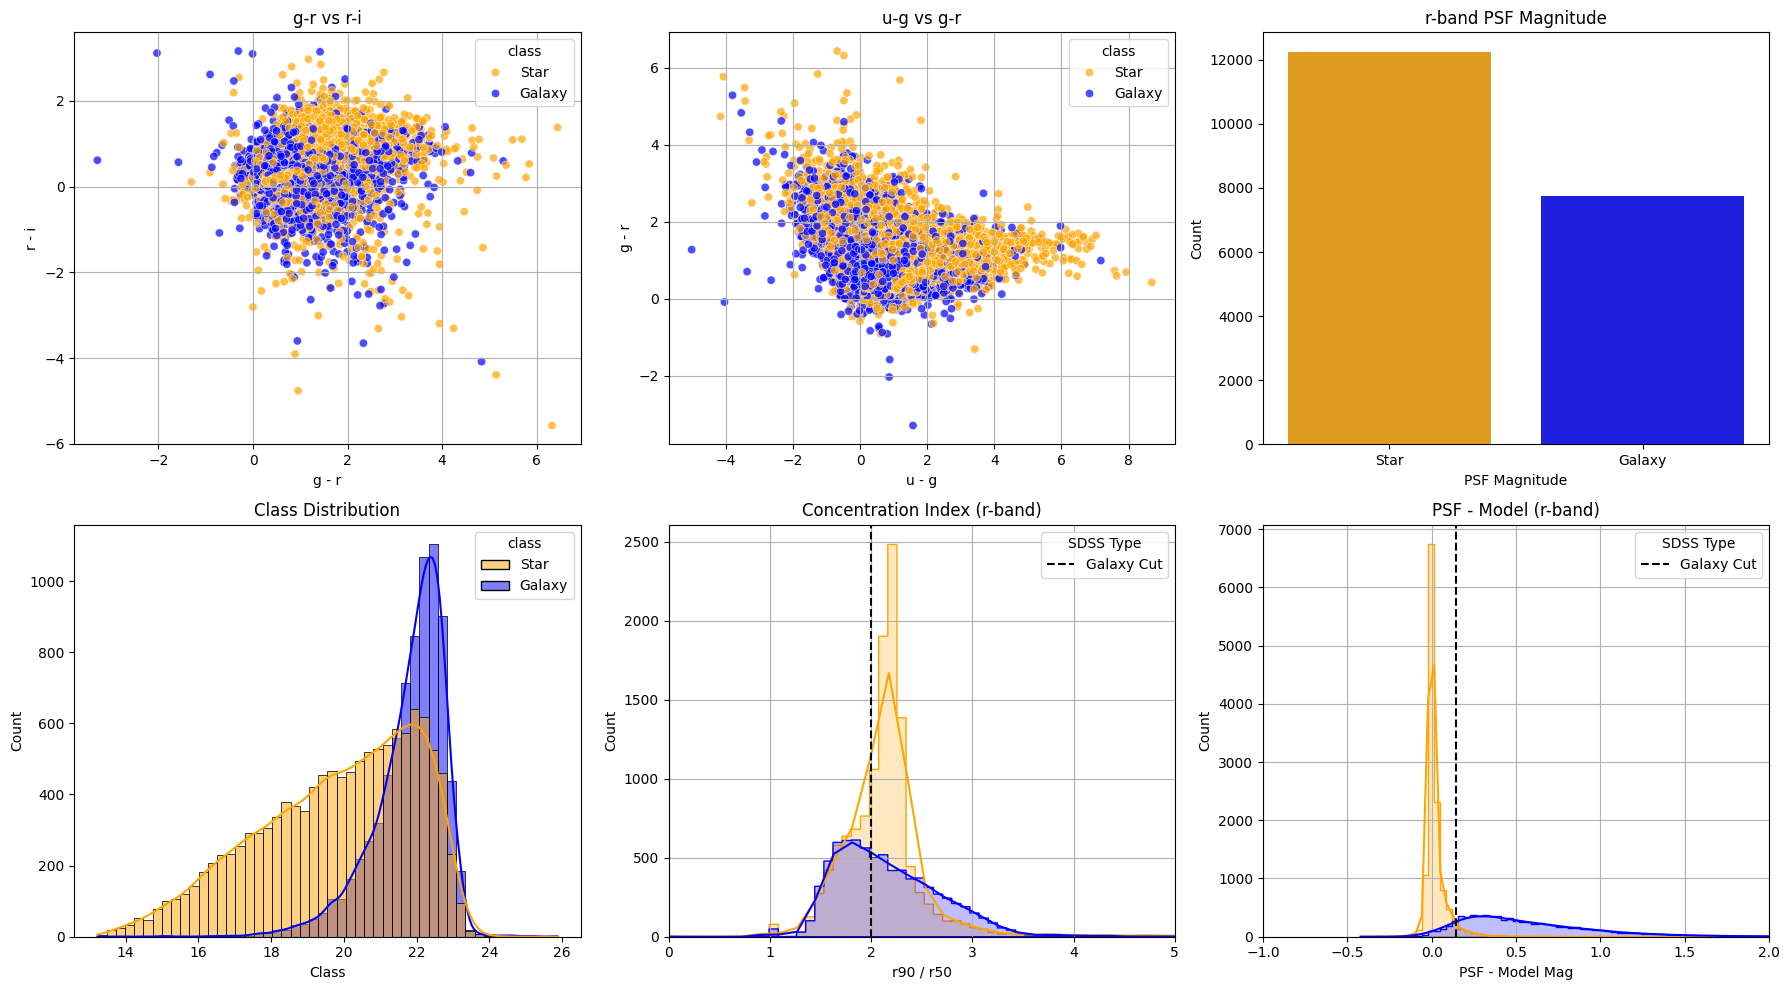

In [4]:
# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# A1. Color-Color: g-r vs r-i
sns.scatterplot(data=df, x='psfMag_(g-r)', y='psfMag_(r-i)', hue='class',
                palette={'Star': 'orange', 'Galaxy': 'blue'}, alpha=0.7, ax=axes[0])
axes[0].set_title('g-r vs r-i')
axes[0].set_xlabel('g - r')
axes[0].set_ylabel('r - i')
axes[0].grid(True)

# A2. Color-Color: u-g vs g-r
sns.scatterplot(data=df, x='psfMag_(u-g)', y='psfMag_(g-r)', hue='class',
                palette={'Star': 'orange', 'Galaxy': 'blue'}, alpha=0.7, ax=axes[1])
axes[1].set_title('u-g vs g-r')
axes[1].set_xlabel('u - g')
axes[1].set_ylabel('g - r')
axes[1].grid(True)

# C. Class Distribution
sns.countplot(x='class', data=df, palette={'Star': 'orange', 'Galaxy': 'blue'},
              hue='class', legend=False, ax=axes[2])
axes[3].set_title('Class Distribution')
axes[3].set_xlabel('Class')
axes[3].set_ylabel('Count')

# B. Magnitude Distribution (r-band)
sns.histplot(data=df, x='psfMag_r', hue='class', kde=True, bins=50,
             palette={'Star': 'orange', 'Galaxy': 'blue'}, stat='count', alpha=0.5, ax=axes[3])
axes[2].set_title('r-band PSF Magnitude')
axes[2].set_xlabel('PSF Magnitude')
axes[2].set_ylabel('Count')

# D. Concentration Index
sns.histplot(data=df, x='concentration_r', hue='type', kde=True, bins=400,
             palette={3: 'blue', 6: 'orange'}, element='step', ax=axes[4])
axes[4].axvline(x=2.0, color='k', linestyle='--', label='Galaxy Cut')
axes[4].set_title('Concentration Index (r-band)')
axes[4].set_xlabel('r90 / r50')
axes[4].set_ylabel('Count')
axes[4].legend(title='SDSS Type')
axes[4].grid(True)
axes[4].set_xlim(0, 5)

# E. PSF - Model Difference
sns.histplot(data=df, x='psf-model', hue='type', kde=True, bins=200,
             palette={3: 'blue', 6: 'orange'}, element='step', ax=axes[5])
axes[5].axvline(x=0.145, color='k', linestyle='--', label='Galaxy Cut')
axes[5].set_title('PSF - Model (r-band)')
axes[5].set_xlabel('PSF - Model Mag')
axes[5].set_ylabel('Count')
axes[5].legend(title='SDSS Type')
axes[5].grid(True)
axes[5].set_xlim(-1, 2)

plt.tight_layout()
plt.show()


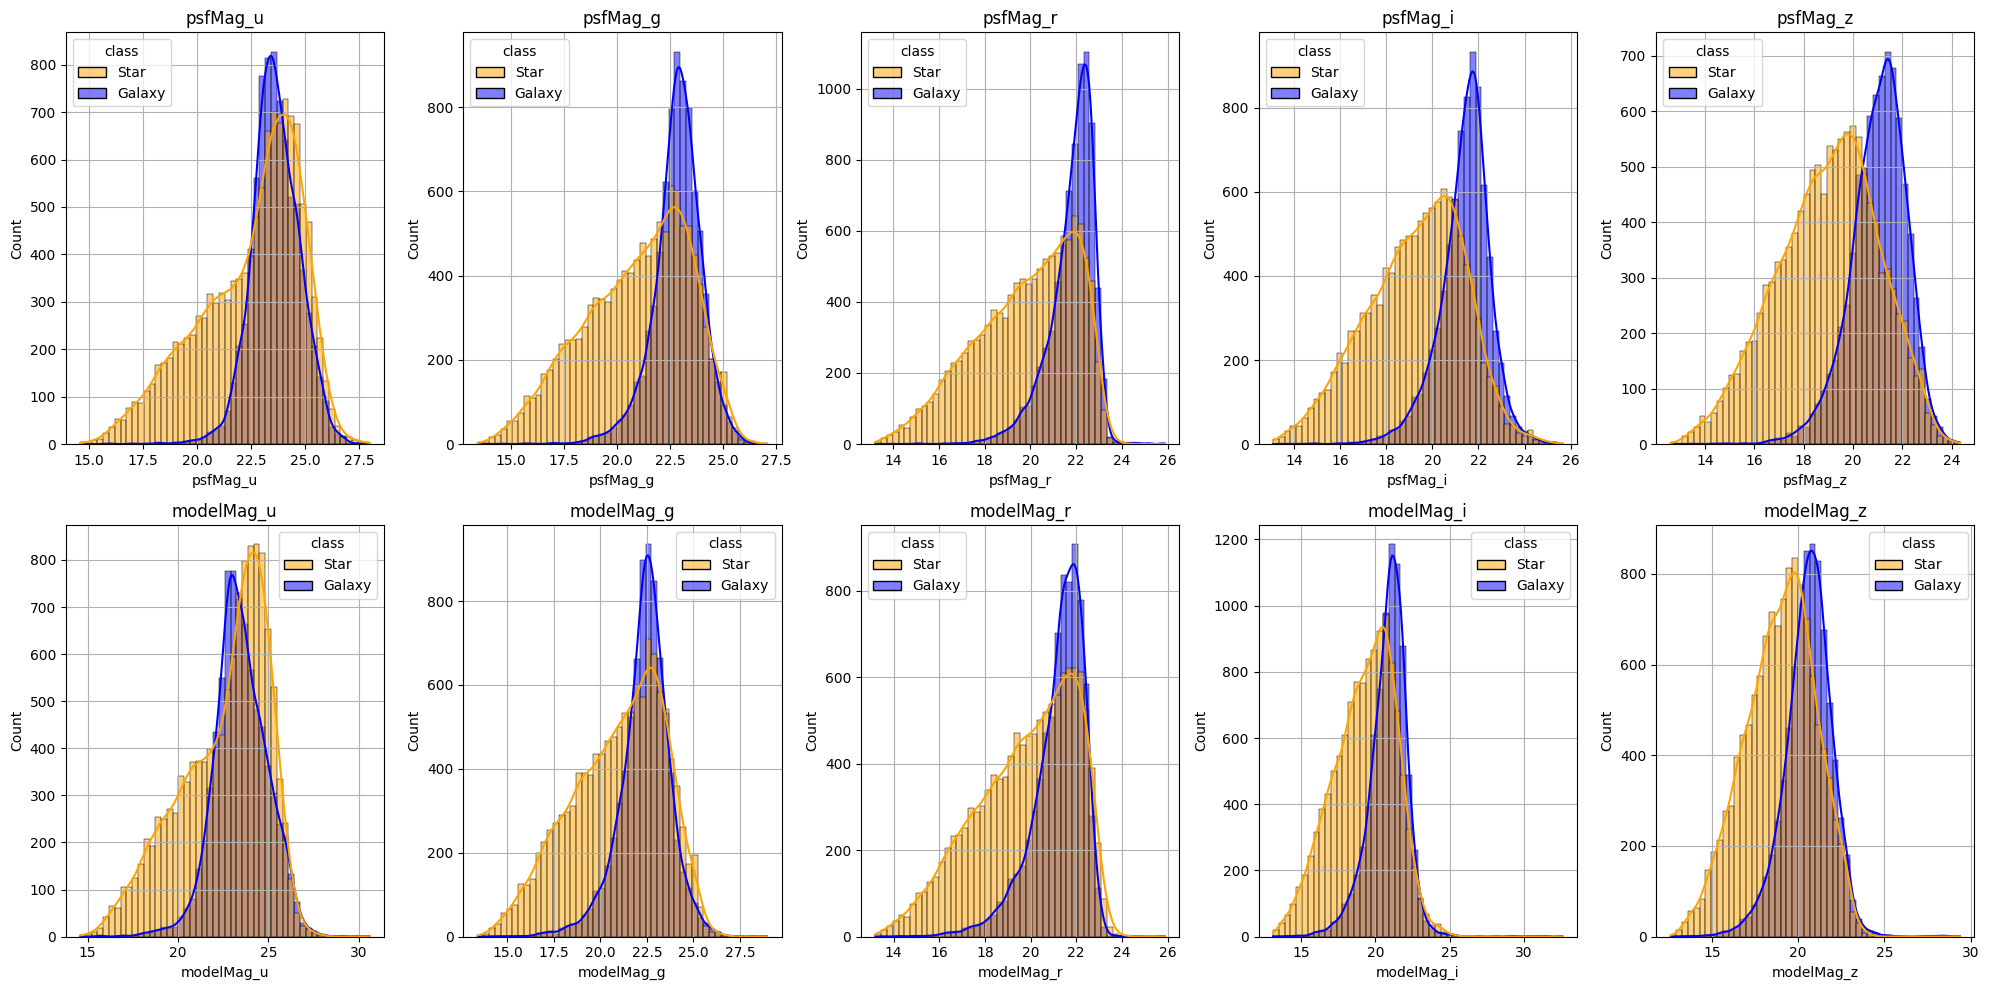

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

# List of magnitude columns to plot
magnitude_columns = [
    'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
    'psfMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r',
    'modelMag_i', 'modelMag_z'
]

# A. Plot histograms for each magnitude
for i, col in enumerate(magnitude_columns):
    sns.histplot(data=df, x=col, hue='class', kde=True, bins=50,
                 palette={'Star': 'orange', 'Galaxy': 'blue'}, stat='count', alpha=0.5, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## 4. **Feature Selection & Engineering**

- Use **physically motivated features** (color indices, concentration index) to enrich the model.
- Ensure that features like **ra**, **dec** are included for spatial analysis or optional clustering tasks.


In [6]:
# Chosen features = psf-model, psfMag_r and concentration_r

## 5. **Modeling**

### A. **Data Splitting**:
- Split the dataset into **training** and **testing** sets (use **stratified sampling** to preserve the star/galaxy distribution).

### B. **Baseline Model**:
- Start with simpler classifiers like **Logistic Regression** or **Decision Trees** to establish a baseline.

### C. **Advanced Models**:
- Experiment with **Random Forest**, **XGBoost**, or **Support Vector Machines** (SVM) for improved classification accuracy.
  
### D. **Model Evaluation**:
- Use metrics like **accuracy**, **precision**, **recall**, **F1-score**, and **confusion matrix** to evaluate the model's performance.
- **Cross-validation**: Use k-fold cross-validation to avoid overfitting and ensure generalization.

### E. **Feature Importance**:
- For tree-based models (Random Forest, XGBoost), examine **feature importance** to see which features (e.g., color indices, concentration index) contribute most to the classification decision.


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2326
           1       0.94      0.97      0.95      3674

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000

XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      2326
           1       0.95      0.97      0.96      3674

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2326
           1       0.95      0.96      0.96      3674

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0

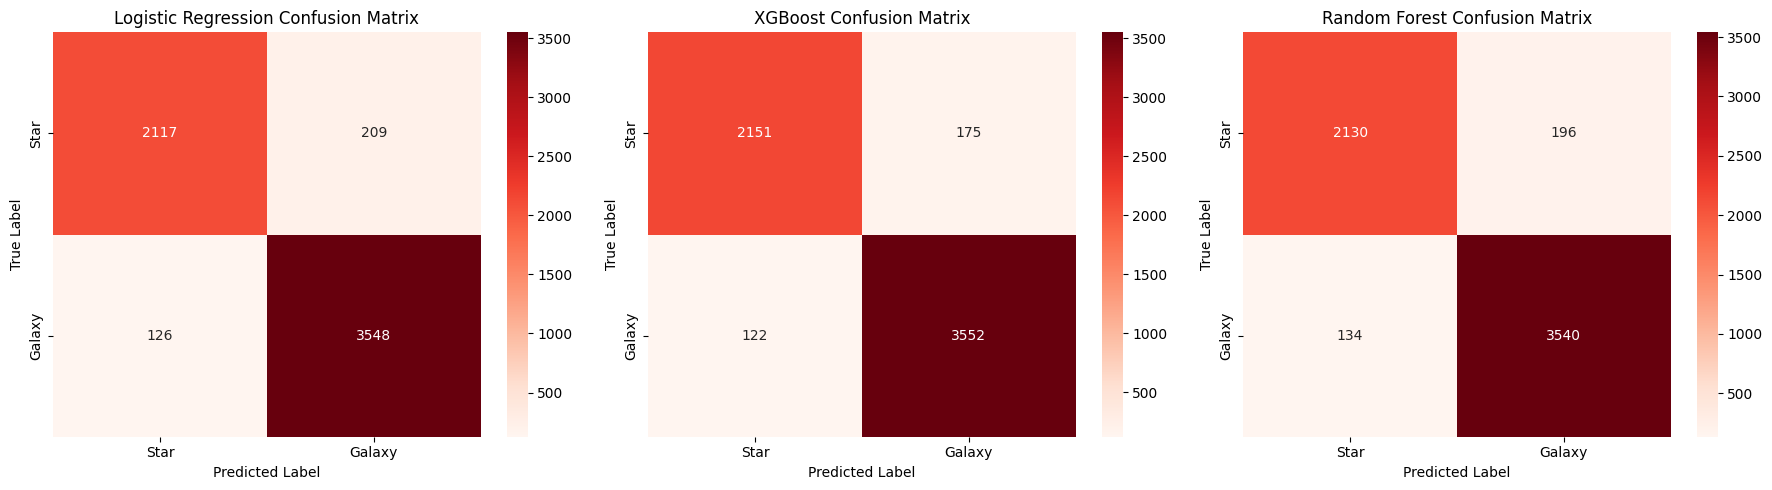

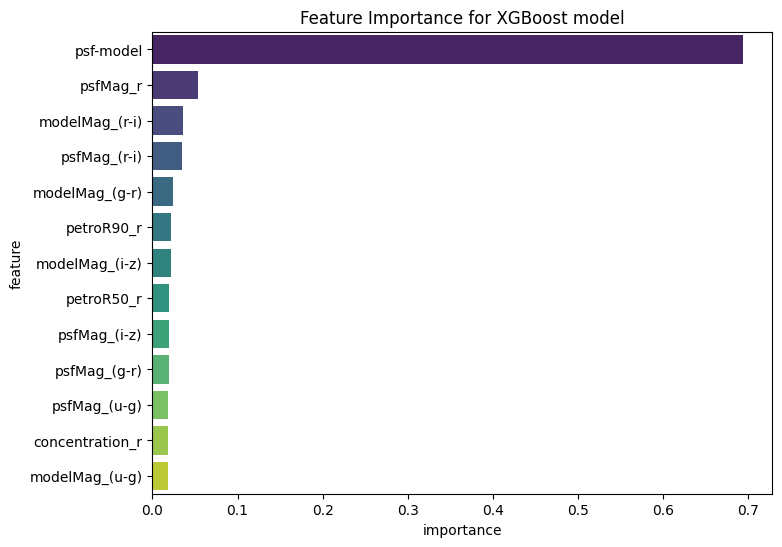

In [30]:
# A. Feature prep and data splits
X = df[['psf-model', 'concentration_r', 'psfMag_r', 'petroR50_r', 'petroR90_r','psfMag_(u-g)',
       'psfMag_(g-r)', 'psfMag_(r-i)', 'psfMag_(i-z)', 'modelMag_(u-g)',
       'modelMag_(g-r)', 'modelMag_(r-i)', 'modelMag_(i-z)']]
y = df['class']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

# B. Basic model - Logistic Regression
model1 = LogisticRegression()
model1.fit(X_train_scaled, y_train)
y_pred = model1.predict(X_test_scaled)

# C. Advanced Models
model2 = XGBClassifier(eval_metric='logloss')
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

model3 = RandomForestClassifier(n_estimators=100, random_state=42)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

# D. Model evaluation
print(f'Logistic Regression Report:\n{classification_report(y_test, y_pred)}')
print(f'XGBoost Classifier Report:\n{classification_report(y_test, y_pred2)}')
print(f'Random Forest Classifier Report:\n{classification_report(y_test, y_pred3)}')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_confusion_matrix(y_test, y_pred, ax=axes[0], title='Logistic Regression Confusion Matrix')
plot_confusion_matrix(y_test, y_pred2, ax=axes[1], title='XGBoost Confusion Matrix')
plot_confusion_matrix(y_test, y_pred3, ax=axes[2], title='Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()

# E. Feature Importances

importances_xgb = model2.feature_importances_
feature_names = X_train.columns

xgb_df = pd.DataFrame({'feature': feature_names, 'importance': importances_xgb}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(data=xgb_df, 
            x='importance', 
            y='feature', 
            hue='feature', 
            palette='viridis',)
plt.title('Feature Importance for XGBoost model')
plt.show()

## 6. **Model Optimization**

### A. **Hyperparameter Tuning**:
- Use **GridSearchCV** or **RandomizedSearchCV** to find the optimal hyperparameters for your chosen models.
- Tune hyperparameters like **max_depth**, **learning_rate**, **n_estimators** for tree-based models.

### B. **Handling Class Imbalance** (if needed):
- If the dataset is imbalanced, try techniques like:
  - **Oversampling** the minority class (SMOTE).
  - **Undersampling** the majority class.
  - **Class weights** adjustment during model training.


Tuned XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2326
           1       0.96      0.97      0.96      3674

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



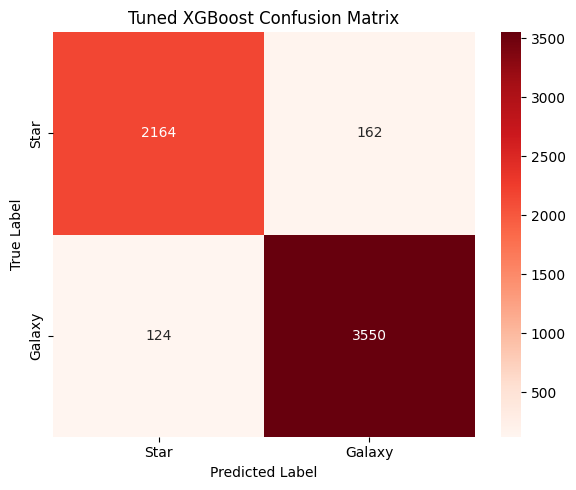

In [52]:
# A. XGBoost Hyperparamter training
'''param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],  # eta
    'n_estimators': [100, 200, 300],  # number of trees
    'max_depth': [6, 8, 10],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 1, 5]
}
model2 = XGBClassifier(eval_metric='logloss')
best_model2 = GridSearchCV(estimator=model2, param_grid=param_grid_xgb, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
best_model2.fit(X_train, y_train)
print(f'Best params: {best_model2.best_params_}')
print(f'Best score: {best_model2.best_score_}')'''

best_params_xgb = {
    'learning_rate': 0.1,  
    'n_estimators': 300,
    'max_depth': 6,
    'min_child_weight': 10,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'gamma': 0
}
best_model2 = XGBClassifier(**best_params_xgb, eval_metric='logloss')
best_model2.fit(X_train, y_train)
best_y_pred2 = best_model2.predict(X_test)
print(f'Tuned XGBoost Classifier Report:\n{classification_report(y_test, best_y_pred2)}')
plot_confusion_matrix(y_test, best_y_pred2, title='Tuned XGBoost Confusion Matrix')
plt.tight_layout()

In [56]:
# B. Handling Class Imbalance
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

best_model2 = XGBClassifier(**best_params_xgb, eval_metric='logloss')
best_model2.fit(X_train_bal, y_train_bal)

best_y_pred2_bal = best_model2.predict(X_test)
print(f'Oversampling Tuned XGBoost Classifier Report:\n{classification_report(y_test, best_y_pred2_bal)}')

Oversampling Tuned XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2326
           1       0.96      0.96      0.96      3674

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



In [53]:
rus = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

best_model2 = XGBClassifier(**best_params_xgb, eval_metric='logloss')
best_model2.fit(X_train_bal, y_train_bal)

best_y_pred2_bal = best_model2.predict(X_test)

print(f'Undersampling Tuned XGBoost Classifier Report:\n{classification_report(y_test, best_y_pred2_bal)}')

Undersampling Tuned XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2326
           1       0.96      0.95      0.96      3674

    accuracy                           0.95      6000
   macro avg       0.94      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



## 7. **Model Interpretation & Analysis**

- Use **SHAP** or **LIME** for model interpretability to explain why certain features (e.g., psf-model, concentration) lead to specific predictions.
- Visualize **feature importance** and explain the physical meaning behind significant features (e.g., why the \( u-g \) color index is a strong discriminator between stars and galaxies).


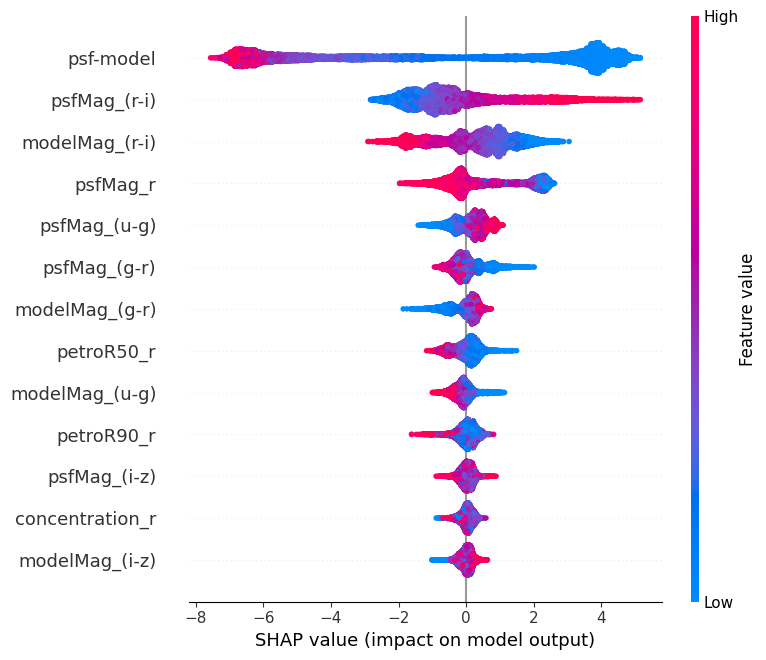

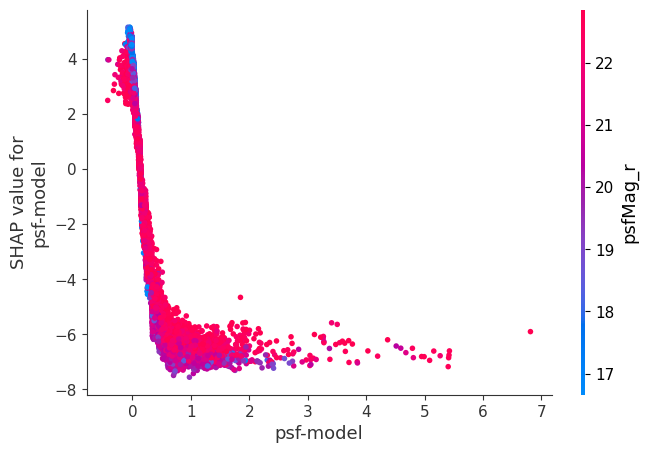

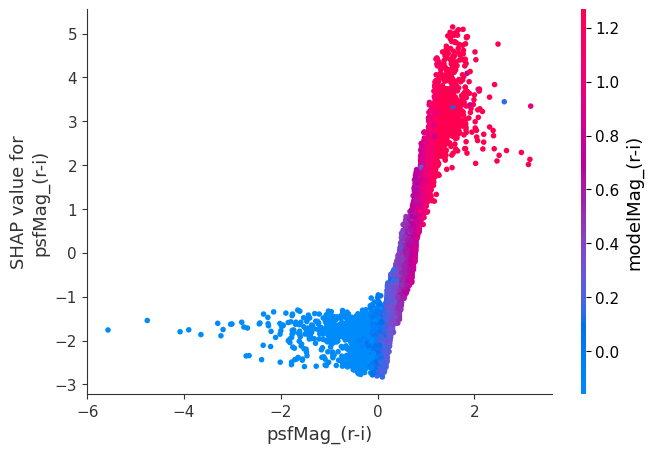

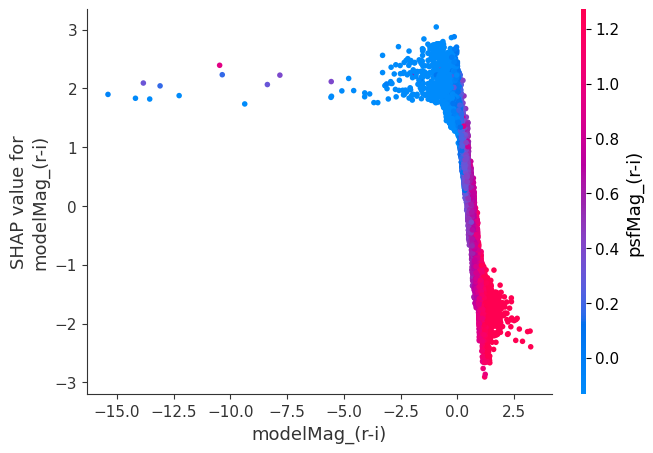

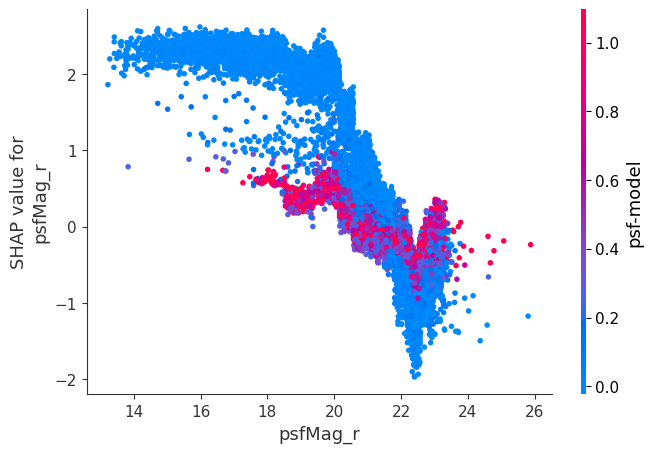

In [66]:
explainer = shap.TreeExplainer(best_model2)
shap_values = explainer.shap_values(X_train_bal)
shap.summary_plot(shap_values, X_train_bal)
shap.dependence_plot('psf-model', shap_values, X_train_bal)
shap.dependence_plot('psfMag_(r-i)', shap_values, X_train_bal)
shap.dependence_plot('modelMag_(r-i)', shap_values, X_train_bal)
shap.dependence_plot('psfMag_r', shap_values, X_train_bal)

## 8. **Reporting & Documentation**

- Write a **README** on GitHub with:
  - Overview of the project.
  - Steps taken (data collection, preprocessing, modeling).
  - Insights gained from EDA and model interpretation.
  - Challenges faced, and how they were addressed.

- **Write a blog post** summarizing the project for a wider audience, explaining both the astrophysical concepts and the machine learning methods you used.


## 9. **Optional Extensions**

- Use **spectroscopic data** from SDSS to validate your photometric classification.
- Apply **unsupervised clustering** (like k-means or DBSCAN) to find natural groupings in the data and explore if any new classes emerge.
- Implement a **deep learning model** (e.g., CNN) to classify objects directly from SDSS images.


# **Project Deliverables**

- **Jupyter Notebook/PyCharm script** with:
  - Data collection and preprocessing.
  - EDA and visualizations.
  - Model training, evaluation, and optimization.
  - Final model and insights.
  
- **GitHub Repository**:
  - Well-documented code.
  - A brief **README** with the project’s goal, results, and steps.
  - Example **visualizations** and **model outputs**.

- **Blog Post or Paper**:
  - High-level summary of your work, including physical interpretations of the key features, classification results, and challenges faced.
